# **Exploring and Analyzing Databases with SQL**

## **Introduction and Objectives**

This project demonstrates advanced SQL skills by querying and analyzing two distinct datasets:

1. A "minified" version of the Internet Movie Database (IMDb). This SQLite database (~10MB) is a tiny sample of the much larger database (more than a few GBs). As a result, disclaimer that we may get wildly different results than if we use the whole database!

2. The money donated during the 2016 election using the Federal Election Commission (FEC)'s public records. We will be connecting to a SQLite database containing the data. The data we will be working with is quite small (~16MB); however, it is a sample taken from a much larger database (more than a few GBs).

Key objectives:
- Querying and joining tables to extract meaningful insights.
- Aggregating, sorting, and filtering data to uncover patterns.
- Demonstrating best practices in SQL and Python integration.

## **Table of Contents**
1. IMDb Dataset Analysis
    1. What are the unique types of titles in the IMDb dataset?
    2. Which job categories are most represented in the film industry?
    3. What are the top 10 films with the highest number of ratings?
    4. How have movie genres evolved over the decades?
    5. Which directors contributed the most to top-rated films?
    6. What are the most common runtime ranges for popular genres?
2. Election Donation Analysis
    1. What insights can we gather about candidates and their committees? 
    2. How much did Donald Trump contribute during the 2016 elections? 
    3. Which committees received the largest aggregate contributions? 
    4. What patterns emerge when analyzing donations by profession? 
    5. Which candidates excelled in fundraising, and how do they compare?
3. Conclusion

### Importing libraries and Loading the dataset

In [99]:
# Run this cell and the next one to set up your notebook.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sqlalchemy
from pathlib import Path
from zipfile import ZipFile

with ZipFile('data.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [64]:
# Run this cell to set up SQL.
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [112]:
from pathlib import Path
import shutil
import pathlib

dbfile = 'imdbmini.db'
if Path('../../../../../../../gradescope').is_dir():
    tmpdb = Path('.') / dbfile 
else:
    tmpdb = Path('../../../../../../../tmp') / dbfile 

if not tmpdb.is_file():
    print('Copying DB file to /tmp for faster access.')
    shutil.copy2(Path('.') / dbfile, tmpdb)
sqlite_conn = 'sqlite:///' + str(tmpdb)

In [113]:
import sqlalchemy

# Create a SQL Alchemy connection to the database.
engine = sqlalchemy.create_engine(sqlite_conn)
connection = engine.connect()

In [114]:
query_tables = """
SELECT sql FROM sqlite_master WHERE type='table';
"""
res_cand_comm = pd.read_sql(query_tables, engine)
res_cand_comm

,sql
0,"CREATE TABLE ""Title"" (\n""tconst"" INTEGER,\n ""..."
1,"CREATE TABLE ""Name"" (\n""nconst"" INTEGER,\n ""p..."
2,"CREATE TABLE ""Role"" (\ntconst INTEGER,\norderi..."
3,"CREATE TABLE ""Rating"" (\ntconst INTEGER,\naver..."


In [115]:
# Table "Title"
query = """
SELECT *
FROM Title
LIMIT 5;
"""

df_title = pd.read_sql(query, engine)
df_title

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,417,short,A Trip to the Moon,Le voyage dans la lune,0,1902,None,13,"Action,Adventure,Comedy"
1,4972,movie,The Birth of a Nation,The Birth of a Nation,0,1915,None,195,"Drama,History,War"
2,10323,movie,The Cabinet of Dr. Caligari,Das Cabinet des Dr. Caligari,0,1920,None,76,"Fantasy,Horror,Mystery"
3,12349,movie,The Kid,The Kid,0,1921,None,68,"Comedy,Drama,Family"
4,13442,movie,Nosferatu,"Nosferatu, eine Symphonie des Grauens",0,1922,None,94,"Fantasy,Horror"


In [117]:
# Table "Name"
query = """
SELECT *
FROM Name
LIMIT 5;
"""

df_name = pd.read_sql(query, engine)
df_name

,nconst,primaryName,birthYear,deathYear,primaryProfession
0,1,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous"
1,2,Lauren Bacall,1924,2014,"actress,soundtrack"
2,3,Brigitte Bardot,1934,None,"actress,soundtrack,music_department"
3,4,John Belushi,1949,1982,"actor,soundtrack,writer"
4,5,Ingmar Bergman,1918,2007,"writer,director,actor"


In [118]:
# Table "Title"
query = """
SELECT *
FROM Role
LIMIT 5;
"""

df_role = pd.read_sql(query, engine)
df_role

,tconst,ordering,nconst,category,job,characters
0,417,1,617588,actor,None,"[""Prof. Barbenfouillis"",""The Moon""]"
1,417,2,29244,actor,None,"[""Astronomer""]"
2,417,3,76933,actress,None,"[""Lady in the Moon""]"
3,417,4,1215996,actor,None,"[""Astronomer""]"
4,417,5,894523,writer,"novel ""De la Terre à la Lune""",None


In [119]:
# Table "Title"
query = """
SELECT *
FROM Rating
LIMIT 5;
"""

df_rating = pd.read_sql(query, engine)
df_rating

,tconst,averageRating,numVotes
0,417,8.2,46382
1,4972,6.3,23836
2,10323,8.1,60244
3,12349,8.3,120059
4,13442,7.9,92218


---

## **1. IMDb Dataset Analysis**

### 1.1 Unique Title Types and Genre Analysis
Identify the unique types of titles in the `Title` table using the `DISTINCT` keyword.

In [10]:
query_q1 = """
SELECT DISTINCT titleType
FROM Title;
"""

res_q1 = pd.read_sql(query_q1, engine)
res_q1

,titleType
0,short
1,movie
2,tvSeries
3,tvMovie
4,tvMiniSeries
5,video
6,videoGame
7,tvEpisode
8,tvSpecial



The dataset contains title types such as "movie", "tvSeries", "tvMiniSeries", and more.


### Genre Trends by Decade
Analyze how genre popularity has changed over decades by grouping titles by their start year and genres.

In [83]:
query_genre_trends = """
WITH GenreDecades AS (
    SELECT 
        (CAST(startYear AS INTEGER) / 10) * 10 AS decade,
        genres,
        COUNT(*) AS count
    FROM Title
    WHERE startYear IS NOT NULL AND genres IS NOT NULL
    GROUP BY decade, genres
)
SELECT 
    decade,
    genres,
    SUM(count) AS total_count
FROM GenreDecades
GROUP BY decade, genres
ORDER BY decade, total_count DESC;
"""

res_genre_trends = pd.read_sql(query_genre_trends, engine)
res_genre_trends

,decade,genres,total_count
0,1900,"Action,Adventure,Comedy",1
1,1910,"Drama,History,War",1
2,1920,"Fantasy,Horror,Short",1
3,1920,"Fantasy,Horror,Mystery",1
4,1920,"Fantasy,Horror",1
...,...,...,...
1381,2020,"Action,Drama",1
1382,2020,"Action,Crime,Sci-Fi",1
1383,2020,"Action,Crime,Horror",1
1384,2020,"Action,Comedy,Romance",1


Now, we need to break down the genres in the movie dataset for deeper insights into their trends across decades. By splitting multi-genre entries into individual components, we can more accurately group and analyze genre popularity over time. We then aggregate the data by decade and genre, identifying the top 10 most prominent genres based on their total counts.

In [84]:
# Split genres into individual entries
res_genre_trends_split = (
    res_genre_trends
    .assign(genres=res_genre_trends['genres'].str.split(','))
    .explode('genres')
    .rename(columns={'genres': 'genre'})
)

# Group by decade and genre, summing counts
grouped_trends = (
    res_genre_trends_split
    .groupby(['decade', 'genre'])['total_count']
    .sum()
    .reset_index()
)

# Get the top 10 genres overall
top_genres = (
    grouped_trends
    .groupby('genre')['total_count']
    .sum()
    .nlargest(10)
    .index
)

# Filter for only top genres, group others into "Other"
grouped_trends['genre'] = grouped_trends['genre'].apply(lambda x: x if x in top_genres else 'Other')
top_trends = (
    grouped_trends
    .groupby(['decade', 'genre'])['total_count']
    .sum()
    .reset_index()
)

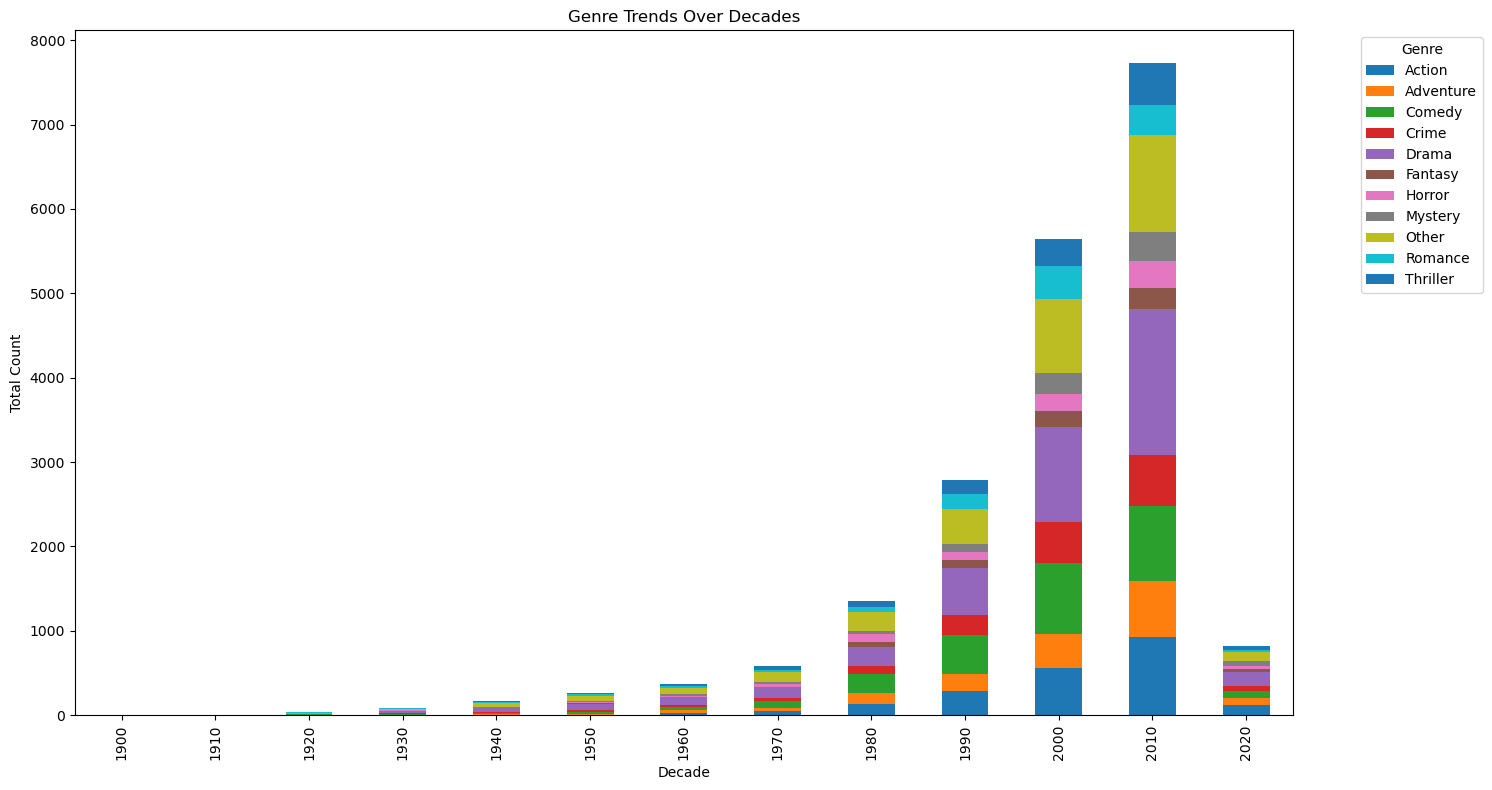

In [85]:
# Pivot for visualization
pivoted_trends = top_trends.pivot(index='decade', columns='genre', values='total_count').fillna(0)

# Plot trends over decades
pivoted_trends.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Genre Trends Over Decades')
plt.xlabel('Decade')
plt.ylabel('Total Count')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Here we can infer that there is an exponential growth in Movie Production. The volume of movies significantly increases starting from the 1970s and peaks during the 2000s and 2010s. Earlier decades (e.g., 1900s–1940s) have very few recorded titles, likely due to limitations in film technology and historical factors like World Wars.

---

### 1.2 Job Categories in the Role Table
Analyze the `Role` table to compute the total number of records for each job category, sorted in descending order.

In [12]:
query_q2 = """
SELECT category, COUNT(*) AS total
FROM Role
GROUP BY category
ORDER BY total DESC;
"""

res_q2 = pd.read_sql(query_q2, engine)
res_q2

,category,total
0,actor,21665
1,writer,13830
2,actress,12175
3,producer,11028
4,director,6995
5,composer,4123
6,cinematographer,2747
7,editor,1558
8,self,623
9,production_designer,410


"Actor" and "Writer" are the most common roles.

### 1.3 Director Contributions to Top-Rated Films
Next, we will evaluate the most influential directors by examining their contributions to top-rated films.


In [13]:
query_directors = """
SELECT Name.primaryName AS director, COUNT(*) AS film_count
FROM Role
JOIN Name ON Role.nconst = Name.nconst
JOIN Title ON Role.tconst = Title.tconst
WHERE Role.category = 'director'
  AND Title.startYear >= 2000
GROUP BY Name.primaryName
ORDER BY film_count DESC
LIMIT 10;
"""

res_directors = pd.read_sql(query_directors, engine)
res_directors

,director,film_count
0,Steven Soderbergh,19
1,Ridley Scott,15
2,Woody Allen,14
3,Steven Spielberg,14
4,Robert Rodriguez,14
5,Ron Howard,13
6,Shawn Levy,12
7,Clint Eastwood,12
8,Tim Burton,11
9,Richard Linklater,11


---

### 1.4 Top 10 Films by Number of Ratings
We want to query the `Rating` table to find the top 10 films with the highest number of votes, along with their average ratings.


In [14]:
query_q3 = """
SELECT primaryTitle AS title, CAST(Rating.numVotes AS int) AS numVotes, averageRating
FROM Rating
JOIN Title
ON Rating.tconst = Title.tconst
ORDER BY numVotes DESC
LIMIT 10;
"""

res_q3 = pd.read_sql(query_q3, engine)
res_q3

,title,numVotes,averageRating
0,The Shawshank Redemption,2462686,9.3
1,The Dark Knight,2417875,9.0
2,Inception,2169255,8.8
3,Fight Club,1939312,8.8
4,Pulp Fiction,1907561,8.9
5,Forrest Gump,1903969,8.8
6,Game of Thrones,1874040,9.2
7,The Matrix,1756469,8.7
8,The Lord of the Rings: The Fellowship of the Ring,1730296,8.8
9,The Lord of the Rings: The Return of the King,1709023,8.9


Films like *The Shawshank Redemption* and *The Dark Knight* have the highest number of ratings.

### 1.5 Most Common Runtime Ranges by Genre
Examine the distribution of runtime across different genres to uncover patterns.

In [94]:
query_runtime_ranges = """
WITH SplitGenres AS (
    SELECT 
        genre,
        CASE
            WHEN CAST(runtimeMinutes AS INT) < 30 THEN 'Short'
            WHEN CAST(runtimeMinutes AS INT) BETWEEN 30 AND 90 THEN 'Feature'
            WHEN CAST(runtimeMinutes AS INT) > 90 THEN 'Long'
            ELSE 'Unknown'
        END AS runtime_category
    FROM (
        SELECT 
            substr(genres, instr(genres, ',') + 1) AS genre,  -- Extract one genre per row
            runtimeMinutes
        FROM Title
        WHERE genres IS NOT NULL AND runtimeMinutes IS NOT NULL
    )
)
SELECT genre, runtime_category, COUNT(*) AS count
FROM SplitGenres
GROUP BY genre, runtime_category
ORDER BY count DESC
LIMIT 10;
"""

res_runtime_ranges = pd.read_sql(query_runtime_ranges, engine)
res_runtime_ranges

,genre,runtime_category,count
0,Drama,Long,544
1,"Crime,Drama",Long,335
2,"Drama,Romance",Long,335
3,Romance,Long,331
4,Thriller,Long,218
5,"Drama,Thriller",Long,198
6,Comedy,Long,163
7,"Mystery,Thriller",Long,157
8,"Drama,Mystery",Long,152
9,"Drama,History",Long,151


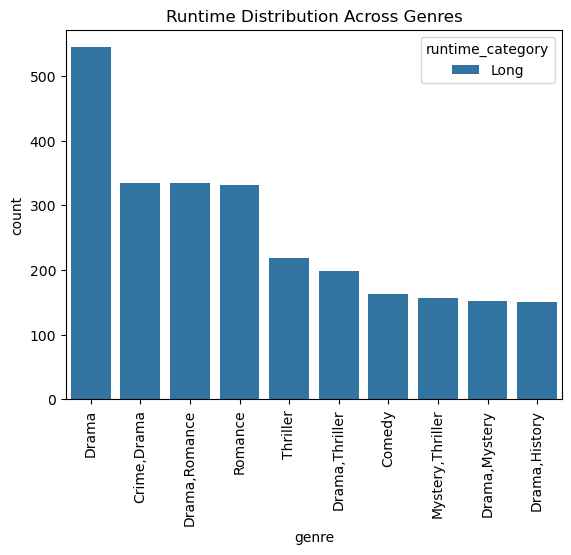

In [98]:
res_runtime_ranges['percent'] = (
    res_runtime_ranges
    .groupby('genre')['count']
    .transform(lambda x: x / x.sum() * 100)
)

sns.barplot(
    data=res_runtime_ranges, 
    x='genre', 
    y='count', 
    hue='runtime_category'
)
plt.xticks(rotation=90)
plt.title('Runtime Distribution Across Genres')
plt.show()

#### Insights:
The overarching trend suggests that genres requiring detailed storytelling, emotional depth, or complex plots (Drama, Romance, Thriller, Mystery, History) are associated with longer runtimes. This aligns with the audience's expectations for these genres, as longer formats allow for more immersive and comprehensive narratives.

### Load Election dataset

In [100]:
dbfile = 'fec_nyc.db'
if Path('../../../../../../../gradescope').is_dir():
    tmpdb = Path('.') / dbfile 
else:
    tmpdb = Path('../../../../../../../tmp') / dbfile 

if not tmpdb.is_file():
    print('Copying DB file to /tmp for faster access.')
    shutil.copy2(Path('.') / dbfile, tmpdb)
    
sqlite_conn_2 = 'sqlite:///' + str(tmpdb)

engine = sqlalchemy.create_engine(sqlite_conn_2)
connection = engine.connect()

In [101]:
query_tables = """
SELECT sql FROM sqlite_master WHERE type='table';
"""
res_cand_comm = pd.read_sql(query_tables, engine)
res_cand_comm

,sql
0,"CREATE TABLE ""cand"" (\n cand_id character v..."
1,"CREATE TABLE ""comm""(\n ""cmte_id"" TEXT,\n ""cm..."
2,CREATE TABLE indiv_sample_nyc (\n cmte_id c...


In [102]:
query_cand = """
SELECT *
FROM cand 
"""

res_cand_comm = pd.read_sql(query_cand, engine)
print('Number of rows:', len(res_cand_comm))
res_cand_comm.head(5)

Number of rows: 7644


,cand_id,cand_name,cand_pty_affiliation,cand_election_yr,cand_office_st,cand_office,cand_office_district,cand_ici,cand_status,cand_pcc,cand_st1,cand_st2,cand_city,cand_st,cand_zip
0,H0AK00097,"COX, JOHN R.",REP,2014,AK,H,0,C,N,C00525261,P.O. BOX 1092,,ANCHOR POINT,AK,99556
1,H0AL02087,"ROBY, MARTHA",REP,2016,AL,H,2,I,C,C00462143,PO BOX 195,,MONTGOMERY,AL,36101
2,H0AL02095,"JOHN, ROBERT E JR",IND,2016,AL,H,2,C,N,,1465 W OVERBROOK RD,,MILLBROOK,AL,36054
3,H0AL05049,"CRAMER, ROBERT E ""BUD"" JR",DEM,2008,AL,H,5,,P,C00239038,PO BOX 2621,,HUNTSVILLE,AL,35804
4,H0AL05163,"BROOKS, MO",REP,2016,AL,H,5,I,C,C00464149,7610 FOXFIRE DRIVE,,HUNTSVILLE,AL,35802


In [103]:
query_comm = """
SELECT *
FROM comm 
"""

res_cand_comm = pd.read_sql(query_comm, engine)
print('Number of rows:', len(res_cand_comm))
res_cand_comm.head(5)

Number of rows: 17812


,cmte_id,cmte_nm,tres_nm,cmte_st1,cmte_st2,cmte_city,cmte_st,cmte_zip,cmte_dsgn,cmte_tp,cmte_pty_affiliation,cmte_filing_freq,org_tp,connected_org_nm,cand_id
0,C00000059,HALLMARK CARDS PAC,ERIN BROWER,2501 MCGEE,MD#288,KANSAS CITY,MO,64108,U,Q,UNK,M,C,,
1,C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,"WALKER, KEVIN","25 MASSACHUSETTS AVE, NW",SUITE 600,WASHINGTON,DC,20001,B,Q,,M,M,AMERICAN MEDICAL ASSOCIATION,
2,C00000489,D R I V E POLITICAL FUND CHAPTER 886,TOM RITTER,3528 W RENO,,OKLAHOMA CITY,OK,73107,U,N,,Q,L,TEAMSTERS LOCAL UNION 886,
3,C00000547,KANSAS MEDICAL SOCIETY POLITICAL ACTION COMMITTEE,"C. RICHARD BONEBRAKE, M.D.",623 SW 10TH AVE,,TOPEKA,KS,66612,U,Q,UNK,Q,T,,
4,C00000638,INDIANA STATE MEDICAL ASSOCIATION POLITICAL AC...,"VIDYA KORA, M.D.","322 CANAL WALK, CANAL LEVEL",,INDIANAPOLIS,IN,46202,U,Q,,Q,M,,


In [104]:
query_indiv_sample_nyc = """
SELECT *
FROM indiv_sample_nyc 
"""

res_indiv_sample_nyc = pd.read_sql(query_indiv_sample_nyc, engine)
print('Number of rows:', len(res_indiv_sample_nyc))
res_indiv_sample_nyc.head(5)

Number of rows: 592464


,cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,...,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id
0,C00445015,N,Q1,P,15951128130,15,IND,"SINGER, TRIPP MR.",NEW YORK,NY,...,"ATLANTIC MAILBOXES, INC.",OWNER,01302015,1000,,A-CF13736,1002485,,,4041420151241812398
1,C00510461,N,Q1,P,15951129284,15E,IND,"SIMON, DANIEL A",NEW YORK,NY,...,N/A,RETIRED,03292015,400,C00401224,VN8JBDDJBA8,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813640
2,C00422410,N,Q1,P,15970352211,15,IND,"ABDUL RAUF, FEISAL",NEW YORK,NY,...,THE CORDOBA INITIATIVE,CHAIRMAN,03042015,250,,VN8A3DBSYG6,1003643,,,4041620151241914560
3,C00510461,N,Q1,P,15951129280,15,IND,"SCHWARZER, FRANK",NEW YORK,NY,...,METRO HYDRAULIC JACK CO,SALES,01162015,100,,VN8JBDAP4C4,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813630
4,C00510461,N,Q1,P,15951129281,15,IND,"SCHWARZER, FRANK",NEW YORK,NY,...,METRO HYDRAULIC JACK CO,SALES,02162015,100,,VN8JBDBRDG3,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813632


---
## **2. Election Donation Analysis**

### 2.1 Candidate and Committee Data Exploration
Explore the `cand` (candidates) and `comm` (committees) tables to understand their structure and relationships.

In [109]:
query_cand_comm = """
SELECT cand_name, cmte_nm
FROM cand AS c1
    INNER JOIN comm AS c2
    ON c1.cand_id = c2.cand_id
ORDER BY cand_name DESC
LIMIT 5;
"""

res_cand_comm = pd.read_sql(query_cand_comm, engine)
res_cand_comm

,cand_name,cmte_nm
0,"ZUTLER, DANIEL PAUL MR",CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT
1,"ZUMWALT, JAMES",ZUMWALT FOR CONGRESS
2,"ZUKOWSKI, ANDREW GEORGE",ZUKOWSKI FOR CONGRESS
3,"ZUCCOLO, JOE",JOE ZUCCOLO FOR CONGRESS
4,"ZORN, ROBERT ERWIN",CONSTITUTIONAL COMMITTEE


### 2.2 Contributions by Donald Trump
Analyze contributions made by or associated with "Donald Trump" to understand the distribution and amounts.

#### Contributions Without Anomalies
Exclude contributions from entities like "DONALD J TRUMP FOR PRESIDENT INC" using the `NOT LIKE` clause.


In [42]:
query_trump_contrib = """
SELECT 
    cmte_id,
    transaction_amt,
    name
FROM indiv_sample_nyc
WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%' AND name NOT LIKE '%INC%';
"""

res_trump_contrib = pd.read_sql(query_trump_contrib, engine)
res_trump_contrib

,cmte_id,transaction_amt,name
0,C00230482,2600,"DONALD, TRUMP"
1,C00230482,2600,"DONALD, TRUMP"
2,C00014498,9000,"TRUMP, DONALD"
3,C00494229,2000,"TRUMP, DONALD MR"
4,C00571869,2700,"TRUMP, DONALD J."
...,...,...,...
137,C00580100,9752,"TRUMP, DONALD J."
138,C00580100,2574,"TRUMP, DONALD J."
139,C00580100,23775,"TRUMP, DONALD J."
140,C00580100,2000000,"TRUMP, DONALD J."


After filtering, 142 unique contributions are identified as directly linked to Donald Trump.

---

### 2.3 Aggregated Contributions by Committees
Aggregate total contributions made to each committee, along with the number of donations, and list them in descending order of the total amount.

In [43]:
query_q6 = """
WITH donations AS (
SELECT comm.cmte_id, cmte_nm, transaction_amt
FROM indiv_sample_nyc
JOIN comm
ON comm.cmte_id = indiv_sample_nyc.cmte_id
      WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%' AND name NOT LIKE '%INC%'
)
SELECT cmte_id, SUM(transaction_amt) AS total_amount, COUNT(*) AS num_donations, cmte_nm
FROM donations
GROUP BY cmte_id
ORDER BY total_amount DESC;
"""

res_q6 = pd.read_sql(query_q6, engine)
res_q6

,cmte_id,total_amount,num_donations,cmte_nm
0,C00580100,18633157,131,"DONALD J. TRUMP FOR PRESIDENT, INC."
1,C00055582,10000,1,NY REPUBLICAN FEDERAL CAMPAIGN COMMITTEE
2,C00014498,9000,1,REPUBLICAN PARTY OF IOWA
3,C00571869,5400,2,DONOVAN FOR CONGRESS
4,C00230482,5200,2,GRASSLEY COMMITTEE INC
5,C00136457,5000,1,NEW HAMPSHIRE REPUBLICAN STATE COMMITTEE
6,C00034033,5000,1,SOUTH CAROLINA REPUBLICAN PARTY
7,C00554949,2600,1,FRIENDS OF DAVE BRAT INC.
8,C00494229,2000,1,HELLER FOR SENATE
9,C00369033,1000,1,TEXANS FOR SENATOR JOHN CORNYN INC


The "DONALD J. TRUMP FOR PRESIDENT, INC." committee received the highest contributions, totaling over $18.6 million across 131 donations.

### 2.4 Donation Patterns by Profession
Identify how the professions of donors influence donation amounts and frequencies.

In [110]:
query_profession = """
SELECT occupation, SUM(transaction_amt) AS total_amount, COUNT(*) AS num_donations
FROM indiv_sample_nyc
GROUP BY occupation
ORDER BY total_amount DESC
LIMIT 10;
"""

res_profession = pd.read_sql(query_profession, engine)
res_profession

,occupation,total_amount,num_donations
0,,92290289,21212
1,EXECUTIVE,33430920,8376
2,CHAIRMAN,27996987,1335
3,RETIRED,21721828,48481
4,PRESIDENT,21259288,2895
5,PRESIDENT/CEO,18973066,205
6,CEO,17721829,3587
7,ATTORNEY,17652952,29537
8,PHILANTHROPIST,13303452,257
9,INVESTOR,12262247,2326


#### Insights:
Certain high-ranking professions, such as CEO, Chairman, President, and President/CEO, contribute disproportionately large amounts in political donations. This highlights how corporate leaders play a pivotal role in funding campaigns. Professions like Philanthropists and President/CEO made fewer donations but contributed substantial amounts, indicating a focus on high-value contributions rather than volume.

Retirees contributed the largest number of donations (48,481), despite a smaller total amount ($21.7M). This suggests retirees are actively engaged in political giving, but their donations are typically smaller in value.

### 2.5 Candidate Performance by Contribution Levels
Analyze how different candidates performed based on the levels of contributions they received.

In [60]:
query_candidate_performance = """
SELECT 
    cand_name, SUM(transaction_amt) AS total_amount, COUNT(*) AS num_donations
FROM indiv_sample_nyc
JOIN comm
ON indiv_sample_nyc.cmte_id = comm.cmte_id
JOIN cand
ON comm.cand_id = cand.cand_id
GROUP BY cand_name
ORDER BY total_amount DESC
LIMIT 10;
"""

res_candidate_performance = pd.read_sql(query_candidate_performance, engine)
res_candidate_performance

,cand_name,total_amount,num_donations
0,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",25099091,110657
1,"TRUMP, DONALD J. / MICHAEL R. PENCE",19260289,1283
2,"RYAN, PAUL D.",5722133,580
3,"SCHUMER, CHARLES E",4449745,2465
4,"BUSH, JEB",2459543,1224
5,"SANDERS, BERNARD",2372332,30537
6,"RUBIO, MARCO",2227550,1834
7,"BENNET, MICHAEL F",1479173,1332
8,"THRONE-HOLST, ANNA",1279351,2378
9,"FEINGOLD, RUSSELL DANA",1268758,2563


The Top Performers:
- Hillary Clinton and Tim Kaine outpaced all other candidates, receiving $25M across 110,657 donations, demonstrating a broad fundraising base and significant financial support during their campaign.

- Donald Trump and Mike Pence, while second in total contributions ($19.3M), had a much smaller number of donations (1,283). This suggests they relied heavily on high-value donations rather than broad grassroots fundraising.

## **3. Conclusion**
IMDb Dataset:

The IMDb dataset analysis highlights the diverse and evolving landscape of modern entertainment. Feature films dominate the dataset, reflecting their longstanding prominence in the industry. Over the decades, genre preferences have shifted significantly, with exponential growth in film production from the 1970s onwards. Drama, action, and adventure consistently lead in popularity, while niche genres experience occasional surges. Visionary directors like Steven Soderbergh and Steven Spielberg play a pivotal role in shaping cinematic trends, producing the most films in recent decades. Additionally, runtime patterns reveal that genres requiring emotional depth, such as drama and romance, favor longer formats to meet audience expectations for immersive storytelling. Viewer preferences, as seen in iconic films like The Shawshank Redemption and The Dark Knight, serve as benchmarks for universal acclaim, showcasing the attributes that resonate most with audiences.

Election Donation Analysis:

The election donation analysis underscores the varied strategies and dynamics of campaign financing. Hillary Clinton and Tim Kaine’s campaign demonstrated a robust grassroots fundraising base, while Donald Trump’s relied heavily on high-value contributions, reflecting contrasting approaches. Corporate leaders, including CEOs, Chairmen, and Presidents, dominate large-scale contributions, highlighting the influence of high-ranking professionals in political funding. Retirees, however, contribute the highest volume of smaller donations, showcasing widespread political engagement from this demographic. Committees, such as "Donald J. Trump for President, Inc.," play a critical role in directing substantial funding, emphasizing their importance in campaign operations.